# ニューラルネットワークの実装

簡単なニューラルネットワークを実装してみる．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

NNは層の組み合わせでできるので，層を実装していく．あとはそれらをまとめられるNNを実装する．

層は関数と見られるので，関数として実装すると良い様に思えるが，層はパラメータを持つのでクラスとして実装する．  
また活性化関数もクラスとして実装する．パラメータは持たないが，逆伝播を行う際に演算結果を保持しておく必要があるため．

層は以下の形で実装する．

```python
class Layer:
    def __init__(self): # パラメータの初期化
        ...

    def __call__(self, x): # 順伝播
        ...

    def backward(self, d): # 逆伝播
        ...

    def update(self, lr): # パラメータの更新
        ...
```

<br>

<u>**メソッドの説明**</u>

- `__init__()`  
パラメータを初期化する．

- `__call__(x)`  
順伝播．演算結果を出力する．

- `backward(d)`  
逆伝播．勾配（順伝播の出力値を入力値で微分した値）を計算し，受け取った勾配(`d`)にかけて次の層に渡す．  
また，パラメータごとの勾配も求め，変数に保持しておく．

- `update(lr)`  
パラメータを更新する．`backward()`で求めた勾配に学習率(`lr`)をかけてパラメータから引く．


---

## 全結合層

全結合層を定義する．

In [2]:
class Linear:
    def __init__(self, n_input, n_output):
        self.w = np.random.normal(size=(n_input, n_output), scale=np.sqrt(2/n_output))
        self.b = np.random.randn(n_output)

    def __call__(self, x):
        self.x = x
        return np.dot(x, self.w) + self.b

    def backward(self, d):
        self.grad_w = np.multiply(*np.meshgrid(d, self.x))
        self.grad_b = d
        return np.dot(d, self.w.T)

    def update(self, lr):
        self.w -= lr * self.grad_w
        self.b -= lr * self.grad_b

\*ミニバッチ非対応

- `__init__()`  
層に入力する値の数（前の層の人工ニューロンの数）と出力する値の数（この層の人工ニューロンの数）を与え，重みとバイアスを初期化する．  
バイアスは標準正規分布を使い，重みはXavierの初期値を使う．重みを標準正規分布にすると値が大きくなりすぎて上手くいかなかったので．

- `__call__()`  
入力と重みの積をとってバイアスを足すだけ．

- `backward()`  
順伝播の演算を$y = x \cdot W + b$と表す．また前の層から伝わってきた勾配を$d$とする．
    - $w$の勾配  
    $y$を$w_{ij}$で微分すると，$w_{ij}$に対応する$x_i$だけが残るので，それに対応する$d_j$をかける．

    - $b$の勾配  
    上式を$b$で微分すると$1$になるので，$d \times 1 = d$が$b$の勾配．

    - $x$の勾配  
    次の層に渡す値．$y$を$x_i$で微分すると，関係のある重み$w_i$と$d$の内積になる．



---

## ReLU

ReLU関数を定義する．

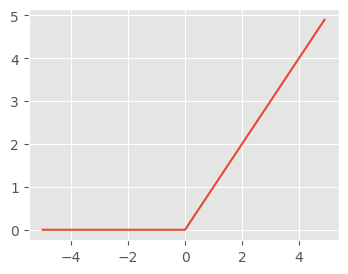

In [3]:
relu = lambda x: np.maximum(x, 0)
x = np.arange(-5, 5, 0.1)
plt.figure(figsize=(4, 3))
plt.plot(x, relu(x));

In [4]:
class ReLU:
    def __call__(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, d):
        return d * (self.x > 0)

    def update(self, lr):
        pass

- `__init__()`  
    パラメータを持たないので何もしない．記述不要．

- `__call__()`  
    入力が0以上ならそれをそのまま出力し，0未満なら0を出力．逆伝播用に入力された値を保持しておく．

- `backward()`  
    勾配は，順伝播時の入力が0以上なら1，0未満なら0なので，それを$d$にかけて次の層に渡す．

- `update()`  
    パラメータを持たないので何もしない．あとで楽するために定義だけしておく．



---

## NN

定義した層をNNとしてまとめるクラスを定義する．  
kerasとかPyTorchでいうところの`Sequential`みたいなやつを目指す．

In [5]:
class NeuralNetwork:
    def __init__(self, *layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, d):
        for layer in self.layers[::-1]:
            d = layer.backward(d)
        return d

    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

- `__init__()`  
    層を順番に入力して初期化する．

- `__call__()`  
    順伝播．`__call__()`メソッドを順番に呼び出すだけ．

- `backward()`  
    逆伝播．`backward()`メソッドを逆順に呼び出すだけ．

- `update()`  
    パラメータの更新．`update()`メソッドを順番に呼び出すだけ．

適当に使ってみよう．

3つの値を入れると2つの値が返ってくるNNを定義する．

In [6]:
nn = NeuralNetwork(
    Linear(3, 10),
    ReLU(),
    Linear(10, 2)
)

これに適当な値を入れてみると

In [7]:
x = np.array([1, 2, 3])
y = nn(x)
y

array([-5.36283948, -0.34391574])

適当な二つの値が出てきた．


---

## 損失関数

損失関数もクラスとして実装する．

### 二乗和誤差

主に回帰問題で使われる損失関数．

In [8]:
class SSE:
    def __call__(self, y, t):
        self.y = y
        self.t = t
        return np.sum((y - t) ** 2) / 2

    def backward(self):
        return self.y - self.t

### 交差エントロピー

これを使う時は，出力層の活性化関数に`softmax`を使う．今回はそれもここにまとめる．

In [9]:
class CrossEntropy:
    def __call__(self, y, t):
        y = self._softmax(y)
        self.y = y
        self.t = t
        loss = -np.sum(t * np.log(y))
        return loss

    def backward(self):
        return self.y - self.t

    def _softmax(self, y):
        return np.exp(y) / np.sum(np.exp(y))

普通活性化関数はNN側に書くけど，softmax関数と交差エントロピーをまとめると微分が綺麗になるので，こっちに書いた．
微分がきれいなのはたまたまではなく，頭のいい人が綺麗になるように考えたからだと思う．


---

## 手書き数字の分類

MNISTというデータセットを使って，手書き数字の分類モデルを作る．

In [10]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 正規化
x_train = x_train.reshape(-1, 784) / 255
x_test = x_test.reshape(-1, 784) / 255

# one-hotに
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

データの中身を見てみる

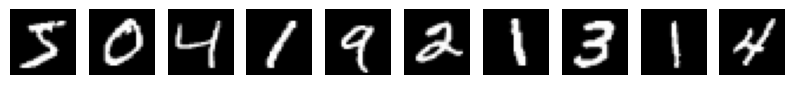

In [11]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

この様な画像から，書かれている数字を予測する．

In [12]:
from tqdm import tqdm

def train(model, x, y, criterion, lr, n_epochs):
    for epoch in range(1, n_epochs+1):
        loss = 0
        for _ in tqdm(range(len(x)), desc=f'{epoch}epoch'):
            # ランダムに一つ抽出
            idx = np.random.randint(0, len(x))
            sample_x = x[idx]
            sample_y = y[idx]

            out = model(sample_x) # 順伝播
            loss += criterion(out, sample_y) # 損失の計算
            d = criterion.backward() # 損失関数の逆伝播
            model.backward(d) # ニューラルネットワークの逆伝播
            model.update(lr) # パラメータの更新
        print(f'loss: {loss / len(x)}')

適当にネットワークを構築する．  
画像を並べた$28 \times 28 = 784$次元のベクトルを入力し，それが0から9のどれに分類されるかを表した10次元のベクトルを出力する．  
出力ベクトルの各要素は，入力が対応するクラスに属する確率を表す．

In [13]:
model = NeuralNetwork(
    Linear(784, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 10)
)
criterion = CrossEntropy()

softmaxは損失関数にまとめているので出力層の活性化関数は設定していない．

ではこれを学習させていく．

In [14]:
train(model, x_train, y_train, criterion, 0.001, 5)

1epoch: 100%|██████████| 60000/60000 [00:45<00:00, 1306.56it/s]


loss: 0.3473260692910298


2epoch: 100%|██████████| 60000/60000 [00:37<00:00, 1607.34it/s]


loss: 0.17441930785197834


3epoch: 100%|██████████| 60000/60000 [00:42<00:00, 1396.54it/s]


loss: 0.13242446609442526


4epoch: 100%|██████████| 60000/60000 [00:44<00:00, 1357.11it/s]


loss: 0.10824699893204048


5epoch: 100%|██████████| 60000/60000 [00:43<00:00, 1391.51it/s]

loss: 0.08368005497731099


損失（loss）がだんだん減っていくのがわかる．

実際に予測させてみよう．

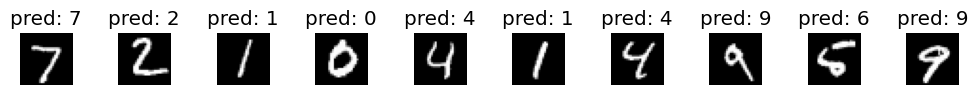

In [15]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    x = x_test[i]
    t = y_test[i]
    pred = np.argmax(model(x))
    ax.imshow(x.reshape(28, 28), cmap='gray')
    ax.set_title(f'pred: {pred}')
    ax.axis('off')
fig.tight_layout()

大体合っているはず